# Import

In [1]:
import sys
import os
sys.path.append("../src")

from utils import *
from mitigation_fct import *
from distance import *
from Gems_Wasserstein import *
from sampling import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from scipy import stats
import ot
import torch
import time

In [ ]:
dic_file = {
    'ASC_INC' : {
        'path' : '../Data/ASCIncome_2023.csv',
    },
    'ASC_TRA' : {
        'path' : '../Data/ACSTravelTime_2023.csv',
    },
    'ASC_MOB' : {
        'path' : '../Data/ACSMobility_2023.csv',
    },
    'ASC_EMP' : {
        'path' : '../Data/ACSEmploymentFiltered_2023.csv',
    },
    'ASC_PUC' : {
        'path' : '../Data/ACSPublicCoverage_2023.csv',
    },
    'BAF' : {
        'path' : '../Data/BAF/Base_mod.csv',
        'model' : Network_old(42, activation_bool = True, n_nodes=1024, n_loop = 2),
    },
    'ADULT' : {
        'path' : '../Data/BAF/Base_mod.csv',
        'model' : Network(34, activation_bool = True, n_nodes=256, n_loop = 2),
    }
}
for folder in ['ASC_INC', 'ASC_TRA', 'ASC_MOB', 'ASC_EMP', 'ASC_PUC']:
    n_column = np.load('./../Result/' + folder + '/X_number_column.npy')
    dic_file[folder]['model'] = Network(n_column, 
                                          activation_bool = True, 
                                          n_nodes=256, n_loop = 2)

In [4]:
dic_sample_size_folder = {
    'ADULT'   : [500, 1000],
    'ASC_EMP' : [2000, 4000],
    'ASC_INC' : [2000, 4000],
    'ASC_MOB' : [2000, 4000],
    'ASC_PUC' : [2000, 4000],
    'ASC_TRA' : [2000, 4000],
    'BAF'     : [2000, 4000],
}

In [ ]:
result_path = '../Result/'
folders_name = dic_sample_size_folder.keys()
dic_arr_results = {}
for folder in folders_name:
    if (folder[-4:] != '.csv') and (folder[-5:] != '.json') and (folder[-4:] != '.npy') :
        print(folder)
        files = os.listdir(result_path + folder)
        if files != []:
            dic_arr_results[folder] = {}
        for file in files:
            if file[-4:] == '.npy':
                try:
                    arr = np.load(file = result_path + folder + '/' + file)
                    dic_arr_results[folder][file[:-4]] = arr
                    print(f'successfuly loaded {file}')
                except:
                    print(f'error with the following : {file}')

ADULT
successfuly loaded DI.npy
successfuly loaded Grad_la_me.npy
successfuly loaded Grad_la_nu.npy
successfuly loaded Grad_reg_me.npy
successfuly loaded Grad_reg_nu.npy
successfuly loaded Miti_Gems_mean.npy
successfuly loaded Miti_Gems_number.npy
successfuly loaded Miti_grad.npy
successfuly loaded Miti_grad_look_alike.npy
successfuly loaded Miti_mod_SF.npy
successfuly loaded Miti_sampling_X.npy
successfuly loaded original.npy
successfuly loaded threshold.npy
ASC_EMP
successfuly loaded DI.npy
successfuly loaded Grad_la_me.npy
successfuly loaded Grad_la_nu.npy
successfuly loaded Grad_reg_me.npy
successfuly loaded Grad_reg_nu.npy
successfuly loaded Miti_Gems_mean.npy
successfuly loaded Miti_Gems_number.npy
successfuly loaded Miti_mod_SF.npy
successfuly loaded Miti_sampling_X.npy
successfuly loaded original.npy
successfuly loaded threshold.npy
successfuly loaded X_number_column.npy
ASC_INC
successfuly loaded DI.npy
successfuly loaded Grad_la_me.npy
successfuly loaded Grad_la_nu.npy
succes

In [ ]:
import json
dic_threshold_path = '../Result/dic_threshold.json'
with open(dic_threshold_path, 'r') as f:
    dic_threshold = json.load(f)
    
dic_highest_to_start = {
    'ADULT'   : 0.75,
    'ASC_EMP' : 0.75,
    'ASC_INC' : 0.95,
    'ASC_MOB' : 0.55,
    'ASC_PUC' : 0.75,
    'ASC_TRA' : 0.95,
    'BAF'     : 0.95,
}

In [7]:
list_method = [
        'Grad_proportional',
        'Grad_balanced', 
        'Grad_proportional_1D-proj',
        'Grad_balanced_1D-proj',
        'Replace_SŶ',
        'Entropic_balanced',
        'Entropic_proportional' ,
        'M_W(XSŶ)',
]

In [ ]:
df_100 = pd.read_csv('../Result/highest_results_100.csv')
DI_start_dic = df_100[df_100.test_result_rejected.isna()].groupby(['Dataset', 'n_sample', 'method']).agg({
    'DI_Qt' : 'max'
}).transpose().to_dict()

In [9]:
np.round(list(DI_start_dic.values())[0]['DI_Qt'], 2)

np.float64(0.45)

# Function

## Regular fonction

In [10]:
def see_highest_DI_undetected(arr_original,
                              mitigation_fct,
                              KL_A_cdt,
                              W_A_cdt,
                              KL_P_cdt,
                              W_P_cdt,
                              number_simu = 50,
                              n_sample = 2000,
                              DI = 0.75,
                              is_entropic_proj = False
                              ):
    
    S_index, Y_index = -2, -1
    max_wass_iter = 1e7
    threshold_pvalue = 0.05
    DI_start = DI_fct(arr_original, 
                      S_index = S_index, 
                      Y_index = Y_index,
                      )
    while DI > DI_start:
        print(DI)
        arr_miti = mitigation_fct(DI = DI)
        indexs = np.arange(len(arr_miti))
        lambdas = arr_miti[:,-1]  
        S0_index_P = arr_original[:,S_index] == 0
        YS0_P, YS1_P = arr_original[S0_index_P, Y_index], arr_original[~S0_index_P, Y_index]

        for i in range(number_simu):
            if is_entropic_proj:
                
                indexs_choice = np.random.choice(indexs,
                                                size = n_sample,
                                                replace = False,
                                                p = lambdas)
                    
                sample = arr_original[indexs_choice]
            else:
                sample = sample_arr(arr_miti, 
                                n_sample)
            
            DI_sample = DI_fct(sample, 
                               S_index = S_index, 
                               Y_index = Y_index)
            
            if DI_sample > DI:

                KL_P_sample = KL_arr(arr_P = arr_original[:,-2:],
                                     arr_Q = sample[:,-2:])
                
                if KL_P_sample < KL_P_cdt:

                    KL_A_sample = KL_arr(arr_P = arr_original,
                                         arr_Q = sample)
                    
                    if KL_A_sample < KL_A_cdt:

                        S0_index_sample = sample[:,S_index] == 0
                        YS0_s = sample[S0_index_sample, Y_index]
                        YS1_s = sample[~S0_index_sample, Y_index]
                        KS1_sample = stats.ks_2samp(YS1_P, YS1_s).pvalue
                        KS0_sample = stats.ks_2samp(YS0_P, YS0_s).pvalue

                        if min(KS0_sample, KS1_sample) > threshold_pvalue:

                            W_P_sample = Wasserstein(arr_original[:,-2:], 
                                                     sample[:,-2:],
                                                     numItermax = max_wass_iter)

                            if W_P_sample < W_P_cdt :

                                W_A_sample = Wasserstein(arr_original, 
                                                         sample,
                                                         numItermax = max_wass_iter)
                                
                                if W_A_sample < W_A_cdt:
                                    return DI_sample
        DI -= 0.05

## All in one

In [ ]:
def give_r_proba(number_simu = 100,
                 S_index = -2,
                 Y_index = -1,
                 give_DI_max_start = False):
    
    '''
    This function gives the results for each DI thresholds, datasets and methods
    '''

    ##Preparation of all mitigation fonctions
    mitigation_fct_S = lambda arr_original, **kwargs : find_sampling_wasserstein_DI(arr = arr_original,
                                                                                    S_index = S_index,
                                                                                    Y_index = Y_index,
                                                                                    **kwargs,
                                                                                    )[0]
    
    mitigation_fct_R = lambda arr_original, **kwargs : find_translation_DI(arr = arr_original,
                                                                           S_index = S_index,
                                                                           Y_index = Y_index,
                                                                           bool_return_all = True,
                                                                           verbose = False,
                                                                           speed = 1,
                                                                           **kwargs,
                                                                           )[0]
    
    mitigation_fct_Ge = lambda arr_original, **kwargs : Gems_fair_mitigation_arr(arr = arr_original,
                                                                                 S_column_index = S_index,
                                                                                 Pred_column_index = Y_index,
                                                                                 **kwargs,
                                                                                 )

    def mitigation_fct_Grad(DI, 
                            arr_original,
                            prob_threshold,
                            folder,
                            look_alike = False,
                            delta_type = 'mean',
                            **kwargs,
                            ):

        model = dic_file[folder]['model']
        #the eval is very important as we use batchnorm layer ! 
        model.eval()
        net_path = '../Result/' + folder + '/net_state_dic.pt'
        model.load_state_dict(torch.load(net_path, weights_only=True))
        stresser = Stresser(X = arr_original[:,:-2].astype(float), 
                            S = arr_original[:,S_index],
                            )

        stresser.W.DI_miti_grad(model,
                                threshold = DI,
                                prob_threshold = prob_threshold,
                                threshold_augm_constr = 0.005,
                                stop_condition_threshold = 0.05,
                                threshold_lr_cdt = 0.1,
                                iteration_threshold = 300,
                                look_alike = look_alike,
                                verbose = False,
                                CONSTR_REGU = 0.1, 
                                lr = 0.1,
                                delta_type = delta_type,
                                )
        new_inputs = stresser.X + stresser.W.t
        pred = (model(torch.from_numpy(new_inputs).float()) > prob_threshold)*1.

        new_arr = np.concatenate([new_inputs, stresser.S.reshape(len(stresser.X), -1), pred], axis = 1)
        return new_arr
    
    dic_method_fct = {
        'Grad_proportional'          : lambda **kwargs : mitigation_fct_Grad(look_alike=False, delta_type='mean', **kwargs), 
        'Grad_balanced'              : lambda **kwargs : mitigation_fct_Grad(look_alike=False, delta_type='number', **kwargs),   
        'Grad_proportional_1D-proj'  : lambda **kwargs : mitigation_fct_Grad(look_alike=True,  delta_type='mean', **kwargs),  
        'Grad_balanced_1D-proj'      : lambda **kwargs : mitigation_fct_Grad(look_alike=True,  delta_type='number', **kwargs),  
        'Replace_SŶ'                 : mitigation_fct_R,
        'M_W(XSŶ)'                   : mitigation_fct_S,
        'Entropic_balanced'          : lambda **kwargs : mitigation_fct_Ge(delta_type = 'number', **kwargs),
        'Entropic_proportional'      : lambda **kwargs : mitigation_fct_Ge(delta_type = 'mean'  , **kwargs),
    }

    ##Iterate the results for every method
    df_result_all_methods = pd.DataFrame({})
    method_list = list(dic_method_fct.keys())
    method_list.reverse()
    for method in tqdm(method_list):
        print(method)
        df_result = give_r_proba_for_a_method(fct = dic_method_fct[method],
                                              number_simu = number_simu,
                                              is_entropic_proj = method in ['Entropic_balanced', 'Entropic_proportional'],
                                              method = method,
                                              give_DI_max_start = give_DI_max_start)
        df_result['method'] = method
        df_result_all_methods = pd.concat([df_result_all_methods, df_result], axis = 0)
        df_result_all_methods.to_csv('./../Result/highest_results_MMD_' + str(number_simu) + '.csv')

    return df_result_all_methods
        

In [12]:
def give_r_proba_for_a_method(fct, 
                              number_simu = 100, 
                              is_entropic_proj = False,
                              S_index = -2, 
                              Y_index = -1,
                              method = 'M_W(XSŶ)',
                              give_DI_max_start = False
                              ):
    '''
    for a specific method, this function gives the results for each DI thresholds and for every dataset
    '''
        
    df_result = pd.DataFrame({})

    for folder in dic_sample_size_folder.keys():
        arr_original = dic_arr_results[folder]['original']
        prob_threshold = torch.tensor(dic_arr_results[folder]['threshold'])

        mitigation_fct = lambda DI : fct(arr_original = arr_original,
                                         threshold = DI,
                                         DI = DI,
                                         DI_target = DI,
                                         prob_threshold = prob_threshold,
                                         folder = folder,
                                         )
        for n_sample in dic_sample_size_folder[folder]:
            print(folder, n_sample)
            DI_max_start = dic_highest_to_start[folder]
            if give_DI_max_start:
                try:
                    DI_max_start = DI_start_dic[(folder, n_sample, method)]['DI_Qt']
                except:
                    print((folder, n_sample, method), 'break')
                    break
            
            KL_A_cdt  = dic_threshold[folder][str(n_sample)]['KL_A']
            W_A_cdt   = dic_threshold[folder][str(n_sample)]['W_A']
            KL_P_cdt  = dic_threshold[folder][str(n_sample)]['KL_P']
            W_P_cdt   = dic_threshold[folder][str(n_sample)]['W_P']
            MMD_A_cdt = dic_threshold[folder][str(n_sample)]['MMD_A']
            MMD_P_cdt = dic_threshold[folder][str(n_sample)]['MMD_P']
            df =  see_highest_DI_undetected_proba(arr_original   = arr_original,
                                                  mitigation_fct = mitigation_fct,
                                                  KL_A_cdt    = KL_A_cdt,
                                                  W_A_cdt     = W_A_cdt,
                                                  MMD_A_cdt   = MMD_A_cdt,
                                                  KL_P_cdt    = KL_P_cdt,
                                                  W_P_cdt     = W_P_cdt,
                                                  MMD_P_cdt   = MMD_P_cdt,
                                                  number_simu = number_simu,
                                                  n_sample    = n_sample,
                                                  DI          = DI_max_start,
                                                  is_entropic_proj  = is_entropic_proj,
                                                  S_index           = S_index, 
                                                  Y_index           = Y_index,
                                                  give_DI_max_start = give_DI_max_start,
                                                  )
            df['Dataset'] = folder
            df_result = pd.concat([df_result, df], axis = 0)
    return df_result


In [13]:
def see_highest_DI_undetected_proba(arr_original,
                                    mitigation_fct,
                                    KL_A_cdt,
                                    W_A_cdt,
                                    MMD_A_cdt,
                                    KL_P_cdt,
                                    W_P_cdt,
                                    MMD_P_cdt,
                                    number_simu = 50,
                                    n_sample = 2000,
                                    DI = 0.75,
                                    is_entropic_proj = False,
                                    S_index = -2, 
                                    Y_index = -1,
                                    give_DI_max_start = None
                                    ):
    '''
    for a specific method and a specific dataset, this function gives the results for each DI thresholds
    '''
    #print('entered see highest')
    max_wass_iter = 1e7
    threshold_pvalue = 0.05
    DI_start = DI_fct(arr_original, 
                    S_index = S_index, 
                    Y_index = Y_index,
                    )
    if give_DI_max_start:
        DI_start = max(np.round(((DI_start*100)//5)*0.05, 3), np.round(DI, 3) - 0.05)
    df_all = pd.DataFrame({})
    i = 0
    '''print(f'the DI is {np.round(DI, 3)}, the DI_start is {DI_start}')'''
    while (np.round(DI, 3) >= DI_start):
        print(DI)
        arr_miti = mitigation_fct(DI = DI + 0.001)
        indexs = np.arange(len(arr_miti))
        lambdas = arr_miti[:,-1]  
        S0_index_P = arr_original[:,S_index] == 0
        YS0_P, YS1_P = arr_original[S0_index_P, Y_index], arr_original[~S0_index_P, Y_index]

        list_sample_time, list_DI_sample, list_sample_test_failed = np.zeros(number_simu), np.zeros(number_simu), []

        for i in range(number_simu):
            start_time = time.time()
            if is_entropic_proj:
                
                indexs_choice = np.random.choice(indexs,
                                                size = n_sample,
                                                replace = False,
                                                p = lambdas)
                    
                sample = arr_original[indexs_choice]
            else:
                sample = sample_arr(arr_miti, 
                                n_sample)
            
            DI_sample = DI_fct(sample, 
                               S_index = S_index, 
                               Y_index = Y_index)
            
            list_DI_sample[i] = DI_sample

            if DI_sample > DI:

                S0_index_sample = sample[:,S_index] == 0
                YS0_s = sample[S0_index_sample, Y_index]
                YS1_s = sample[~S0_index_sample, Y_index]
                KS1_sample = stats.ks_2samp(YS1_P, YS1_s).pvalue
                KS0_sample = stats.ks_2samp(YS0_P, YS0_s).pvalue

                if min(KS0_sample, KS1_sample) > threshold_pvalue:
                     
                    KL_P_sample = KL_arr(arr_P = arr_original[:,-2:],
                                     arr_Q = sample[:,-2:])
                
                    if KL_P_sample < KL_P_cdt:

                        KL_A_sample = KL_arr(arr_P = arr_original,
                                            arr_Q = sample)
                        
                        if KL_A_sample < KL_A_cdt:

                            MMD_P_sample = mmd_rbf(arr_original[:,-2:], sample[:,-2:])

                            if MMD_P_sample < MMD_P_cdt:

                                MMD_A_sample = mmd_rbf(arr_original, sample)

                                if MMD_A_sample < MMD_A_cdt:

                                    W_P_sample = Wasserstein(arr_original[:,-2:], 
                                                            sample[:,-2:],
                                                            numItermax = max_wass_iter)

                                    if W_P_sample < W_P_cdt :

                                        W_A_sample = Wasserstein(arr_original, 
                                                                sample,
                                                                numItermax = max_wass_iter)
                                        
                                        if W_A_sample < W_A_cdt:
                                            list_sample_test_failed.append('None')
                                        else:
                                            list_sample_test_failed.append('W_A')
                                    else:
                                        list_sample_test_failed.append('W_P')
                                else:
                                    list_sample_test_failed.append('MMD_A')
                            else:
                                list_sample_test_failed.append('MMD_P')
                        else:
                            list_sample_test_failed.append('KL_P')
                    else:
                        list_sample_test_failed.append('KL_A')
                else:
                    list_sample_test_failed.append('KS')
            else:
                list_sample_test_failed.append('DI')

            end_time = time.time()
            elipsed_time = end_time - start_time
            list_sample_time[i] = elipsed_time

        DI -= 0.05
        df = pd.DataFrame({'DI_sample' : list_DI_sample, 
                           'test_result_rejected' : list_sample_test_failed, 
                           'DI_Qt' : [DI] * number_simu,
                           'n_sample' : [n_sample] * number_simu,
                           'sampling_test_time' : list_sample_time,
                           'iter_number' : np.arange(1,number_simu + 1, 1)})
        df_all = pd.concat([df_all, df], axis = 0)
    return df_all

# Applications

## Result with probabilities

#### test

In [11]:
df = give_r_proba( number_simu = 1)

  0%|          | 0/8 [00:00<?, ?it/s]

Entropic_proportional
ADULT 500
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ADULT 1000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ASC_EMP 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_EMP 4000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_INC 2000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_INC 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_MOB 2000
0.55
0.5
0.45
ASC_MOB 4000
0.55
0.5
0.45
ASC_PUC 2000
0.75
0.7
0.64999

 12%|█▎        | 1/8 [05:56<41:36, 356.70s/it]

Entropic_balanced
ADULT 500
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ADULT 1000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ASC_EMP 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_EMP 4000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_INC 2000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_INC 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_MOB 2000
0.55
0.5
0.45
ASC_MOB 4000
0.55
0.5
0.45
ASC_PUC 2000
0.75
0.7
0.649999999

 25%|██▌       | 2/8 [11:28<34:13, 342.32s/it]

M_W(XSŶ)
ADULT 500
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ADULT 1000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ASC_EMP 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_EMP 4000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_INC 2000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_INC 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_MOB 2000
0.55
0.5
0.45
ASC_MOB 4000
0.55
0.5
0.45
ASC_PUC 2000
0.75
0.7
0.6499999999999999
0

 38%|███▊      | 3/8 [8:25:33<19:03:32, 13722.51s/it]

Replace_SŶ
ADULT 500
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ADULT 1000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ASC_EMP 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_EMP 4000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_INC 2000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_INC 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_MOB 2000
0.55
0.5
0.45
ASC_MOB 4000
0.55
0.5
0.45
ASC_PUC 2000
0.75
0.7
0.6499999999999999

 50%|█████     | 4/8 [8:26:42<9:15:28, 8332.09s/it]  

Grad_balanced_1D-proj
ADULT 500
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ADULT 1000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ASC_EMP 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_EMP 4000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_INC 2000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_INC 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_MOB 2000
0.55
0.5
0.45
ASC_MOB 4000
0.55
0.5
0.45
ASC_PUC 2000
0.75
0.7
0.64999

 62%|██████▎   | 5/8 [15:08:45<11:41:19, 14026.53s/it]

Grad_proportional_1D-proj
ADULT 500
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ADULT 1000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ASC_EMP 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_EMP 4000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_INC 2000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_INC 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_MOB 2000
0.55
0.5
0.45
ASC_MOB 4000
0.55
0.5
0.45
ASC_PUC 2000
0.75
0.7
0.6

 75%|███████▌  | 6/8 [22:27:51<10:07:09, 18214.99s/it]

Grad_balanced
ADULT 500
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ADULT 1000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ASC_EMP 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_EMP 4000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_INC 2000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_INC 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_MOB 2000
0.55
0.5
0.45
ASC_MOB 4000
0.55
0.5
0.45
ASC_PUC 2000
0.75
0.7
0.6499999999999

 88%|████████▊ | 7/8 [23:18:28<3:40:53, 13253.14s/it] 

Grad_proportional
ADULT 500
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ADULT 1000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ASC_EMP 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_EMP 4000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_INC 2000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_INC 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_MOB 2000
0.55
0.5
0.45
ASC_MOB 4000
0.55
0.5
0.45
ASC_PUC 2000
0.75
0.7
0.649999999

100%|██████████| 8/8 [24:16:48<00:00, 10926.07s/it]  


In [16]:
df.sort_values('sampling_test_time')

,DI_sample,test_result_rejected,DI_Qt,n_sample,sampling_test_time,iter_number,Dataset,method
0,0.282191,DI,0.30,500,0.000146,1,ADULT,Replace_SŶ
0,0.292481,DI,0.25,500,0.000156,1,ADULT,Replace_SŶ
0,0.380886,DI,0.35,500,0.000159,1,ADULT,Replace_SŶ
0,0.350633,DI,0.40,500,0.000159,1,ADULT,Replace_SŶ
0,0.290399,DI,0.35,1000,0.000170,1,ADULT,Replace_SŶ
...,...,...,...,...,...,...,...,...
0,0.449140,None,0.35,4000,47.184350,1,BAF,M_W(XSŶ)
0,0.454514,None,0.40,4000,47.483175,1,ASC_MOB,M_W(XSŶ)
0,0.506580,None,0.30,4000,48.706760,1,BAF,Entropic_proportional
0,0.736039,None,0.45,4000,50.724435,1,BAF,Entropic_proportional


#### Result before MMD

In [ ]:
df_100 = give_r_proba( number_simu = 100)

In [ ]:
df_100 = pd.read_csv('../Result/highest_results_100.csv')

In [31]:
df_100.test_result_rejected.value_counts()

test_result_rejected
DI      48566
KL_P    28363
KL_A     8131
W_A       284
W_P       155
Name: count, dtype: int64

In [13]:
df_100.test_result_rejected.isna().mean()

np.float64(0.045770089285714285)

In [14]:
df_100

,Unnamed: 0,DI_sample,test_result_rejected,DI_Qt,n_sample,sampling_test_time,iter_number,Dataset,method
0,0,0.624952,DI,0.7,500,0.000471,1,ADULT,Entropic_proportional
1,1,0.617733,DI,0.7,500,0.000345,2,ADULT,Entropic_proportional
2,2,0.767552,KL_P,0.7,500,0.004786,3,ADULT,Entropic_proportional
3,3,0.765441,KL_P,0.7,500,0.004379,4,ADULT,Entropic_proportional
4,4,0.634706,DI,0.7,500,0.000390,5,ADULT,Entropic_proportional
...,...,...,...,...,...,...,...,...,...
89595,95,0.778230,KL_A,0.3,4000,4.175326,96,BAF,Grad_proportional
89596,96,0.415943,KL_A,0.3,4000,4.254991,97,BAF,Grad_proportional
89597,97,0.416846,KL_A,0.3,4000,4.209489,98,BAF,Grad_proportional
89598,98,0.273035,DI,0.3,4000,0.000910,99,BAF,Grad_proportional


In [61]:
df_100[df_100.test_result_rejected.isna()].groupby(['method', 'Dataset', 'n_sample', 'DI_Qt']).agg({
    'iter_number' : 'min'
}).iter_number.std()

np.float64(20.75566827069484)

In [77]:
df_100[df_100.test_result_rejected.isna()].groupby(['method', 'Dataset', 'n_sample', 'DI_Qt']).agg({
    'iter_number' : 'min'
}).iter_number.mean()

np.float64(11.2)

In [63]:
(df_100[df_100.test_result_rejected.isna()].groupby(['method', 'Dataset', 'n_sample', 'DI_Qt']).agg({
    'iter_number' : 'min'
}).iter_number < 30).mean()

np.float64(0.8944444444444445)

In [75]:
(df_100[df_100.test_result_rejected.isna()].groupby(['method', 'Dataset', 'n_sample', 'DI_Qt']).agg({
    'iter_number' : 'min'
}).iter_number > 20).sum()

np.int64(24)

In [64]:
(df_100[df_100.test_result_rejected.isna()].groupby(['method', 'Dataset', 'n_sample', 'DI_Qt']).agg({
    'iter_number' : 'min'
}).iter_number > 30).sum()

np.int64(19)

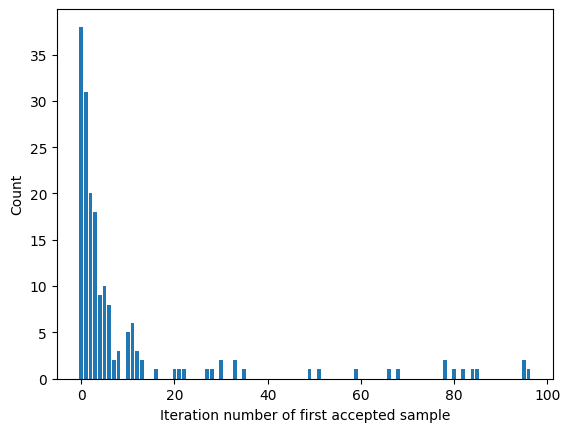

In [66]:
values, count = np.unique(df_100[df_100.test_result_rejected.isna()].groupby(['method', 'Dataset', 'n_sample', 'DI_Qt']).agg({
    'iter_number' : 'min'
}).iter_number, return_counts = True)
plt.bar(values - 1, count)
plt.xlabel("Iteration number of first accepted sample")
plt.ylabel("Count")
plt.show()

In [69]:
np.median(df_100[df_100.test_result_rejected.isna()].groupby(['method', 'Dataset', 'n_sample', 'DI_Qt']).agg({
    'iter_number' : 'min'
}).iter_number)

np.float64(4.0)

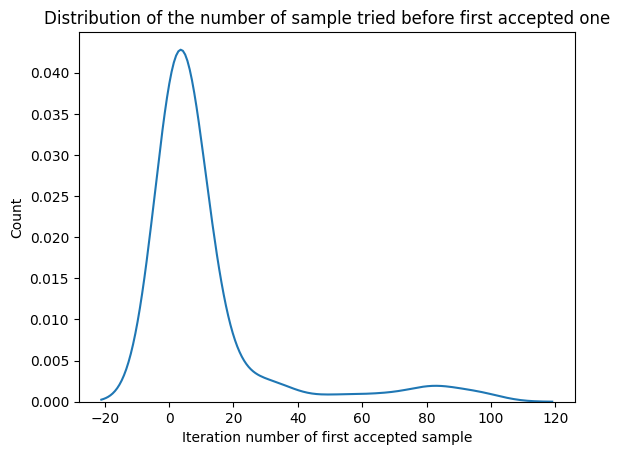

In [64]:
values, count = np.unique(df_100[df_100.test_result_rejected.isna()].groupby(['method', 'Dataset', 'n_sample', 'DI_Qt']).agg({
    'iter_number' : 'min'
}).iter_number, return_counts = True)
sns.kdeplot(df_100[df_100.test_result_rejected.isna()].groupby(['method', 'Dataset', 'n_sample', 'DI_Qt']).agg({
    'iter_number' : 'min'
}).iter_number)
plt.xlabel("Iteration number of first accepted sample")
plt.ylabel("Count")
plt.title('Distribution of the number of sample tried before first accepted one')
plt.show()

<Axes: xlabel='Dataset', ylabel='DI_sample'>

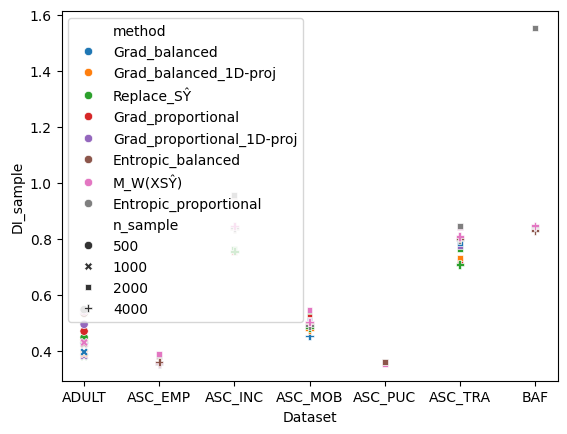

In [89]:
df = df_100[df_100.test_result_rejected.isna()].groupby(['Dataset', 'n_sample', 'method']).agg({
    'DI_sample' : 'max',
}).sort_values(['Dataset', 'n_sample', 'DI_sample']).reset_index()
sns.scatterplot(data = df, x = 'Dataset', y = 'DI_sample', style='n_sample', hue = 'method')

<Axes: xlabel='Dataset', ylabel='DI_sample'>

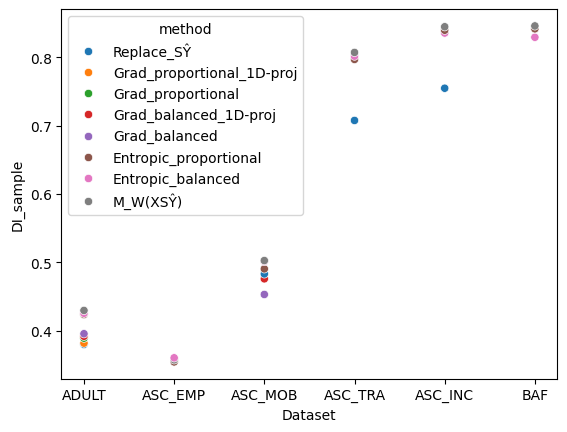

In [95]:
df = df_100[df_100.test_result_rejected.isna()].groupby(['Dataset', 'n_sample', 'method']).agg({
    'DI_sample' : 'max',
}).sort_values(['n_sample', 'DI_sample']).reset_index()
sns.scatterplot(data = df[(df.n_sample == 4000) | (df.n_sample == 1000)], x = 'Dataset', y = 'DI_sample', hue = 'method')

In [81]:
print(df_100.fillna('None').groupby(['n_sample', 'test_result_rejected']).agg({
    'sampling_test_time' : 'mean',
}).sort_values(['n_sample', 'test_result_rejected',  'sampling_test_time']).reset_index().to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrlr}
\toprule
 & n_sample & test_result_rejected & sampling_test_time \\
\midrule
0 & 500 & DI & 0.00 \\
1 & 500 & KL_A & 0.78 \\
2 & 500 & KL_P & 0.00 \\
3 & 500 & None & 1.53 \\
4 & 500 & W_A & 1.55 \\
5 & 500 & W_P & 1.07 \\
6 & 1000 & DI & 0.00 \\
7 & 1000 & KL_A & 0.85 \\
8 & 1000 & KL_P & 0.00 \\
9 & 1000 & None & 2.39 \\
10 & 1000 & W_A & 2.42 \\
11 & 2000 & DI & 0.00 \\
12 & 2000 & KL_A & 3.15 \\
13 & 2000 & KL_P & 0.02 \\
14 & 2000 & None & 22.64 \\
15 & 2000 & W_A & 23.59 \\
16 & 2000 & W_P & 8.08 \\
17 & 4000 & DI & 0.00 \\
18 & 4000 & KL_A & 3.36 \\
19 & 4000 & KL_P & 0.02 \\
20 & 4000 & None & 43.60 \\
21 & 4000 & W_A & 45.23 \\
22 & 4000 & W_P & 12.94 \\
\bottomrule
\end{tabular}



In [51]:
df = df_100[df_100.test_result_rejected.isna()].groupby(['Dataset', 'method', 'n_sample']).agg({
    'DI_sample' : 'max'
}).reset_index()

In [33]:
l_d = []
l_s_z = []
l_m = []
l_d_s = []
for m in range(len(list_method)):
    l_d_s.append([])
for d in dic_sample_size_folder.keys():
    for s_z in dic_sample_size_folder[d]:
        l_d.append(d)
        l_s_z.append(s_z)
        for count, m in enumerate(list_method):
            try:
                l_d_s[count].append(min(df[(df.Dataset == d) & (df.method == m) & (df.n_sample == s_z)].DI_sample.item(), 1))
            except:
                l_d_s[count].append('--')
df_r = pd.DataFrame({'Dataset' : l_d, 'Sample size' : l_s_z})#'Method' : l_m, 'Highest Sample DI' : l_d_s
for count, m in enumerate(list_method):
    df_r[m] = l_d_s[count]
df_r

,Dataset,Sample size,Grad_proportional,Grad_balanced,Grad_proportional_1D-proj,Grad_balanced_1D-proj,Replace_SŶ,Entropic_balanced,Entropic_proportional,M_W(XSŶ)
0,ADULT,500,0.469668,0.427767,0.494253,0.43955,0.447964,0.533571,0.54662,0.541369
1,ADULT,1000,0.388889,0.395382,0.381629,0.391682,0.379747,0.425397,0.423469,0.429477
2,ASC_EMP,2000,--,--,--,--,--,0.382561,0.385998,0.388757
3,ASC_EMP,4000,--,--,--,--,--,0.360094,0.354082,0.357174
4,ASC_INC,2000,0.750514,--,--,--,0.762263,0.953085,0.954466,0.952318
5,ASC_INC,4000,--,--,--,--,0.754933,0.835787,0.839877,0.844965
6,ASC_MOB,2000,0.532262,0.508301,--,0.502171,0.541396,0.53175,0.506112,0.545463
7,ASC_MOB,4000,--,0.452897,--,0.475783,0.483007,0.50139,0.490398,0.502536
8,ASC_PUC,2000,--,--,--,--,--,0.360458,0.358439,0.352893
9,ASC_PUC,4000,--,--,--,--,--,--,--,--


In [52]:
l_d = []
l_s_z = []
l_m = []
l_d_s = []
for m in range(len(list_method)):
    l_d_s.append([])
for d in dic_sample_size_folder.keys():
    for s_z in dic_sample_size_folder[d]:
        l_d.append(d)
        l_s_z.append(s_z)
        for count, m in enumerate(list_method):
            try:
                l_d_s[count].append(min(df[(df.Dataset == d) & (df.method == m) & (df.n_sample == s_z)].DI_sample.item(), 1))
            except:
                l_d_s[count].append(float('nan'))
df_r = pd.DataFrame({'Dataset' : l_d, 'Sample size' : l_s_z})#'Method' : l_m, 'Highest Sample DI' : l_d_s
for count, m in enumerate(list_method):
    df_r[m] = l_d_s[count]
df_r

,Dataset,Sample size,Grad_proportional,Grad_balanced,Grad_proportional_1D-proj,Grad_balanced_1D-proj,Replace_SŶ,Entropic_balanced,Entropic_proportional,M_W(XSŶ)
0,ADULT,500,0.469668,0.427767,0.494253,0.439550,0.447964,0.533571,0.546620,0.541369
1,ADULT,1000,0.388889,0.395382,0.381629,0.391682,0.379747,0.425397,0.423469,0.429477
2,ASC_EMP,2000,NaN,NaN,NaN,NaN,NaN,0.382561,0.385998,0.388757
3,ASC_EMP,4000,NaN,NaN,NaN,NaN,NaN,0.360094,0.354082,0.357174
4,ASC_INC,2000,0.750514,NaN,NaN,NaN,0.762263,0.953085,0.954466,0.952318
5,ASC_INC,4000,NaN,NaN,NaN,NaN,0.754933,0.835787,0.839877,0.844965
6,ASC_MOB,2000,0.532262,0.508301,NaN,0.502171,0.541396,0.531750,0.506112,0.545463
7,ASC_MOB,4000,NaN,0.452897,NaN,0.475783,0.483007,0.501390,0.490398,0.502536
8,ASC_PUC,2000,NaN,NaN,NaN,NaN,NaN,0.360458,0.358439,0.352893
9,ASC_PUC,4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
print(df_r.to_latex(float_format="{:.2f}".format))

\begin{tabular}{llrllllllll}
\toprule
 & Dataset & Sample size & Grad_proportional & Grad_balanced & Grad_proportional_1D-proj & Grad_balanced_1D-proj & Replace_SŶ & Entropic_balanced & Entropic_proportional & M_W(XSŶ) \\
\midrule
0 & ADULT & 500 & 0.47 & 0.43 & 0.49 & 0.44 & 0.45 & 0.53 & 0.55 & 0.54 \\
1 & ADULT & 1000 & 0.39 & 0.40 & 0.38 & 0.39 & 0.38 & 0.43 & 0.42 & 0.43 \\
2 & ASC_EMP & 2000 & -- & -- & -- & -- & -- & 0.38 & 0.39 & 0.39 \\
3 & ASC_EMP & 4000 & -- & -- & -- & -- & -- & 0.36 & 0.35 & 0.36 \\
4 & ASC_INC & 2000 & 0.75 & -- & -- & -- & 0.76 & 0.95 & 0.95 & 0.95 \\
5 & ASC_INC & 4000 & -- & -- & -- & -- & 0.75 & 0.84 & 0.84 & 0.84 \\
6 & ASC_MOB & 2000 & 0.53 & 0.51 & -- & 0.50 & 0.54 & 0.53 & 0.51 & 0.55 \\
7 & ASC_MOB & 4000 & -- & 0.45 & -- & 0.48 & 0.48 & 0.50 & 0.49 & 0.50 \\
8 & ASC_PUC & 2000 & -- & -- & -- & -- & -- & 0.36 & 0.36 & 0.35 \\
9 & ASC_PUC & 4000 & -- & -- & -- & -- & -- & -- & -- & -- \\
10 & ASC_TRA & 2000 & 0.72 & 0.79 & 0.77 & 0.73 & 0.76 & 0.8

#### With MMD

In [ ]:
df_100 = give_r_proba(number_simu = 99,
                      give_DI_max_start = True)

In [ ]:
df_100_MMD = pd.read_csv('../Result/highest_results_MMD_100.csv')

In [37]:
df_100_MMD.test_result_rejected.value_counts(dropna = False)

test_result_rejected
DI       3620
NaN      2440
KL_A      855
KL_P      165
W_A       135
MMD_A     120
MMD_P      74
KS         59
W_P        32
Name: count, dtype: int64

In [50]:
df = df_100_MMD[df_100_MMD.test_result_rejected.isna()].groupby(['Dataset', 'method', 'n_sample']).agg({
    'DI_sample' : 'max'
}).reset_index()

l_d = []
l_s_z = []
l_m = []
l_d_s = []
for m in range(len(list_method)):
    l_d_s.append([])
for d in dic_sample_size_folder.keys():
    for s_z in dic_sample_size_folder[d]:
        l_d.append(d)
        l_s_z.append(s_z)
        for count, m in enumerate(list_method):
            try:
                l_d_s[count].append(min(df[(df.Dataset == d) & (df.method == m) & (df.n_sample == s_z)].DI_sample.item(), 1))
            except:
                l_d_s[count].append(float('nan'))
df_r_MMD = pd.DataFrame({'Dataset' : l_d, 'Sample size' : l_s_z})#'Method' : l_m, 'Highest Sample DI' : l_d_s
for count, m in enumerate(list_method):
    df_r_MMD[m] = l_d_s[count]
df_r_MMD

,Dataset,Sample size,Grad_proportional,Grad_balanced,Grad_proportional_1D-proj,Grad_balanced_1D-proj,Replace_SŶ,Entropic_balanced,Entropic_proportional,M_W(XSŶ)
0,ADULT,500,NaN,NaN,NaN,NaN,0.499370,0.543253,0.520048,0.535225
1,ADULT,1000,NaN,NaN,NaN,NaN,0.405538,0.418469,0.412780,0.420306
2,ASC_EMP,2000,NaN,NaN,NaN,NaN,NaN,0.356350,0.357850,0.372860
3,ASC_EMP,4000,NaN,NaN,NaN,NaN,NaN,0.340533,0.361100,0.348557
4,ASC_INC,2000,NaN,NaN,NaN,NaN,0.884268,0.944648,0.947658,0.930433
5,ASC_INC,4000,NaN,NaN,NaN,NaN,0.830833,0.827122,0.842215,0.843641
6,ASC_MOB,2000,NaN,NaN,NaN,NaN,0.534688,0.524995,NaN,0.521042
7,ASC_MOB,4000,NaN,NaN,NaN,NaN,0.495209,0.500186,NaN,0.502094
8,ASC_PUC,2000,NaN,NaN,NaN,NaN,NaN,0.332060,0.348039,0.348794
9,ASC_PUC,4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
df_r_MMD[df_r_MMD['Sample size'] == 2000][['Dataset', 'M_W(XSŶ)']].round(2)

,Dataset,M_W(XSŶ)
2,ASC_EMP,0.37
4,ASC_INC,0.93
6,ASC_MOB,0.52
8,ASC_PUC,0.35
10,ASC_TRA,0.85
12,BAF,1.00


In [58]:
-(df_r_MMD[['Replace_SŶ',	'Entropic_balanced',	'Entropic_proportional',	'M_W(XSŶ)']] - df_r[['Replace_SŶ',	'Entropic_balanced',	'Entropic_proportional',	'M_W(XSŶ)']]).round(2)

,Replace_SŶ,Entropic_balanced,Entropic_proportional,M_W(XSŶ)
0,-0.05,-0.01,0.03,0.01
1,-0.03,0.01,0.01,0.01
2,NaN,0.03,0.03,0.02
3,NaN,0.02,-0.01,0.01
4,-0.12,0.01,0.01,0.02
5,-0.08,0.01,-0.00,0.00
6,0.01,0.01,NaN,0.02
7,-0.01,0.00,NaN,0.00
8,NaN,0.03,0.01,0.00
9,NaN,NaN,NaN,NaN


## With Matching

In [ ]:
dic_result = { 
}

for folder in dic_sample_size_folder.keys():
    if folder not in dic_result.keys():
        dic_result[folder] = {}
    for n_sample in dic_sample_size_folder[folder]:
        if n_sample not in dic_result[folder].keys():
            print(folder, n_sample)
            arr_original = dic_arr_results[folder]['original']
            mitigation_fct = lambda DI : find_sampling_wasserstein_DI(arr = arr_original,
                                                            threshold = DI,
                                                            S_index = -2,
                                                            Y_index = -1,
                                                            )[0]
            KL_A_cdt = dic_threshold[folder][str(n_sample)]['KL_A']
            W_A_cdt  = dic_threshold[folder][str(n_sample)]['W_A']
            KL_P_cdt = dic_threshold[folder][str(n_sample)]['KL_P']
            W_P_cdt  = dic_threshold[folder][str(n_sample)]['W_P']
            dic_result[folder][n_sample] =  see_highest_DI_undetected(arr_original   = arr_original,
                                                            mitigation_fct = mitigation_fct,
                                                            KL_A_cdt    = KL_A_cdt,
                                                            W_A_cdt     = W_A_cdt,
                                                            KL_P_cdt    = KL_P_cdt,
                                                            W_P_cdt     = W_P_cdt,
                                                            number_simu = 75,
                                                            n_sample = n_sample,
                                                            DI = dic_highest_to_start[folder],
                                                            )
            print(dic_result[folder][n_sample])


ASC_MOB 4000
0.55
0.5
0.45
0.46857063345740424
ASC_PUC 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.35395945192618017
ASC_PUC 4000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
None
ASC_TRA 2000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.8241046482092965
ASC_TRA 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.8014217701878767
BAF 2000
0.95
1.0313390313390314
BAF 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.7948717948717949


ADULT 0.3 0.52
ASC_EMP 0.3 0.36
ASC_INC 0.67 0.96
ASC_MOB 0.45 0.54
ASC_PUC 0.32 0.35
ASC_TRA 0.69 0.82
BAF 0.35 1.03


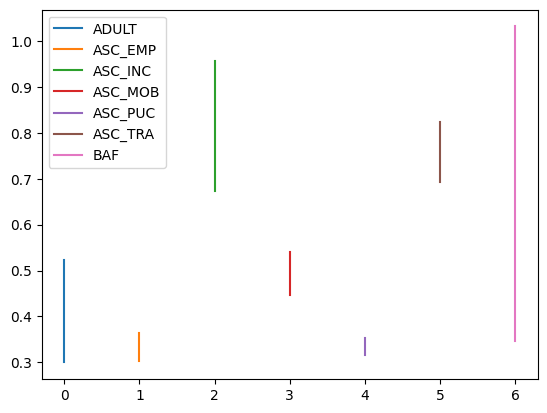

In [ ]:
folders_name = dic_sample_size_folder.keys()
for count, folder in enumerate(folders_name):
    DI_ini = np.load('../Result/' + folder + '/DI.npy')
    plt.plot([count, count], [DI_ini, dic_result[folder][dic_sample_size_folder[folder][0]]], label = folder)
    print(folder, DI_ini.round(2), np.round((dic_result[folder][dic_sample_size_folder[folder][0]]), 2))
plt.legend()
plt.show()

In [ ]:
with open('../Result/Highest_DI_Matching.json', "w") as f:
    json.dump(dic_result, f) 

## With replace

In [11]:
mitigation_fct_R = lambda **kwargs : find_translation_DI(S_index = -2,
                                                        Y_index = -1,
                                                        bool_return_all = True,
                                                        verbose = False,
                                                        speed = 1,
                                                        **kwargs,
                                                        )[0]
arr_original = dic_arr_results[folder]['original']
mitigation_fct = lambda DI : mitigation_fct_R(arr = arr_original,
                                threshold = DI,
                                DI = DI,
                                DI_target = DI,
                                )

In [12]:
df_result = give_r_proba_for_a_method(fct = mitigation_fct_R, 
                                      number_simu=5)

ADULT 500
(5000, 36)
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ADULT 1000
(5000, 36)
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
ASC_EMP 2000
(20000, 17)
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_EMP 4000
(20000, 17)
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
ASC_INC 2000
(20000, 10)
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_INC 4000
(20000, 10)
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
ASC_MOB 2000
(20000, 21)
0.55
0.5
0

c:\Users\Valentin\Documents\FairWashing\Inspection\Project\../src\utils.py:194: RuntimeWarning: divide by zero encountered in scalar divide
  DI =  PY1S0 / PY1S1


0.7499999999999998
0.6999999999999997
0.6499999999999997
0.5999999999999996
0.5499999999999996
0.4999999999999996
0.4499999999999996
0.39999999999999963
0.34999999999999964
BAF 4000
(20000, 44)
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
0.6499999999999997
0.5999999999999996
0.5499999999999996
0.4999999999999996
0.4499999999999996
0.39999999999999963
0.34999999999999964


In [ ]:
dic_result = { }
S_index, Y_index = -2, -1
for folder in dic_sample_size_folder.keys():
    if folder not in dic_result.keys():
        dic_result[folder] = {}
    for n_sample in dic_sample_size_folder[folder]:
        if n_sample not in dic_result[folder].keys():
            print(folder, n_sample)
            arr_original = dic_arr_results[folder]['original']
            mitigation_fct_R = lambda DI : find_translation_DI(arr = arr_original,
                                                   S_index = S_index,
                                                   Y_index = Y_index,
                                                   threshold = DI,
                                                   bool_return_all = True,
                                                   verbose = False,
                                                   speed = 1,
                                                   )[0]
            KL_A_cdt = dic_threshold[folder][str(n_sample)]['KL_A']
            W_A_cdt  = dic_threshold[folder][str(n_sample)]['W_A']
            KL_P_cdt = dic_threshold[folder][str(n_sample)]['KL_P']
            W_P_cdt  = dic_threshold[folder][str(n_sample)]['W_P']
            dic_result[folder][n_sample] =  see_highest_DI_undetected(arr_original   = arr_original,
                                                            mitigation_fct = mitigation_fct_R,
                                                            KL_A_cdt    = KL_A_cdt,
                                                            W_A_cdt     = W_A_cdt,
                                                            KL_P_cdt    = KL_P_cdt,
                                                            W_P_cdt     = W_P_cdt,
                                                            number_simu = 75,
                                                            n_sample = n_sample,
                                                            DI = dic_highest_to_start[folder],
                                                            )
            print(dic_result[folder][n_sample])


ADULT 500
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.37471980074719796
ADULT 1000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
0.32329839193396365
ASC_EMP 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
None
ASC_EMP 4000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
None
ASC_INC 2000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
0.7271689497716894
ASC_INC 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
None
ASC_MOB 2000
0.55
0.5
0.45
0.45475254254120673
ASC

c:\Users\Valentin\Documents\FairWashing\Inspection\Project\../src\utils.py:194: RuntimeWarning: divide by zero encountered in scalar divide
  DI =  PY1S0 / PY1S1


0.7999999999999998
0.7499999999999998
0.6999999999999997
0.6499999999999997
0.5999999999999996
0.5499999999999996
0.4999999999999996
0.4499999999999996
0.39999999999999963
0.34999999999999964
None
BAF 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
0.6499999999999997
0.5999999999999996
0.5499999999999996
0.4999999999999996
0.4499999999999996
0.39999999999999963
0.34999999999999964
None


ADULT 0.3 0.37
ASC_EMP 0.3 None
ASC_INC 0.67 0.73
ASC_MOB 0.45 0.45
ASC_PUC 0.32 None
ASC_TRA 0.69 0.74
BAF 0.35 None


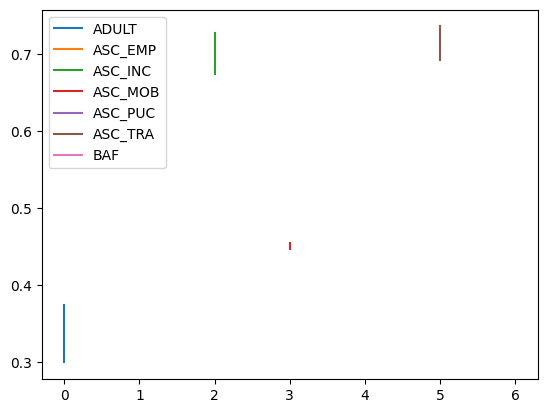

In [ ]:
for count, folder in enumerate(folders_name):
    DI_ini = np.load('../Result/' + folder + '/DI.npy')
    plt.plot([count, count], [DI_ini, dic_result[folder][dic_sample_size_folder[folder][0]]], label = folder)
    new_DI = dic_result[folder][dic_sample_size_folder[folder][0]]
    if new_DI is None:
        print(folder, DI_ini.round(2), None)
    else:
        print(folder, DI_ini.round(2), np.round((new_DI), 2))
plt.legend()
plt.show()

## With Gems balanced

In [14]:
dic_result = { 
}

for folder in dic_sample_size_folder.keys():
    if folder not in dic_result.keys():
        dic_result[folder] = {}
    for n_sample in dic_sample_size_folder[folder]:
        if n_sample not in dic_result[folder].keys():
            print(folder, n_sample)
            arr_original = dic_arr_results[folder]['original']
            mitigation_fct_Ge_b = lambda DI : Gems_fair_mitigation_arr(arr=arr_original, 
                                                            S_column_index = -1,
                                                            Pred_column_index = -2,
                                                            DI_target = DI,
                                                            delta_type = 'number')
            KL_A_cdt = dic_threshold[folder][str(n_sample)]['KL_A']
            W_A_cdt  = dic_threshold[folder][str(n_sample)]['W_A']
            KL_P_cdt = dic_threshold[folder][str(n_sample)]['KL_P']
            W_P_cdt  = dic_threshold[folder][str(n_sample)]['W_P']
            dic_result[folder][n_sample] =  see_highest_DI_undetected(arr_original   = arr_original,
                                                            mitigation_fct = mitigation_fct_Ge_b,
                                                            KL_A_cdt    = KL_A_cdt,
                                                            W_A_cdt     = W_A_cdt,
                                                            KL_P_cdt    = KL_P_cdt,
                                                            W_P_cdt     = W_P_cdt,
                                                            number_simu = 75,
                                                            n_sample = n_sample,
                                                            DI = dic_highest_to_start[folder],
                                                            is_entropic_proj=True
                                                            )
            print(dic_result[folder][n_sample])


ADULT 500
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
None
ADULT 1000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
None
ASC_EMP 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
None
ASC_EMP 4000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
None
ASC_INC 2000
0.95
0.8999999999999999
0.9009712105445716
ASC_INC 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
None
ASC_MOB 2000
0.55
0.5
0.45
None
ASC_MOB 4000
0.55
0.5
0.45
None
ASC_PUC 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.54999999999

ADULT 0.3 None
ASC_EMP 0.3 None
ASC_INC 0.67 0.9
ASC_MOB 0.45 None
ASC_PUC 0.32 None
ASC_TRA 0.69 0.8
BAF 0.35 0.95


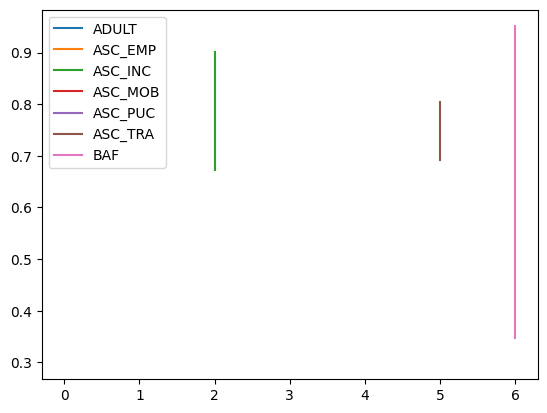

In [ ]:
for count, folder in enumerate(folders_name):
    DI_ini = np.load('../Result/' + folder + '/DI.npy')
    plt.plot([count, count], [DI_ini, dic_result[folder][dic_sample_size_folder[folder][0]]], label = folder)
    new_DI = dic_result[folder][dic_sample_size_folder[folder][0]]
    if new_DI is None:
        print(folder, DI_ini.round(2), None)
    else:
        print(folder, DI_ini.round(2), np.round((new_DI), 2))
plt.legend()
plt.show()

## With Gems proportionnal 

In [20]:
dic_result = { 
}

for folder in dic_sample_size_folder.keys():
    if folder not in dic_result.keys():
        dic_result[folder] = {}
    for n_sample in dic_sample_size_folder[folder]:
        if n_sample not in dic_result[folder].keys():
            print(folder, n_sample)
            arr_original = dic_arr_results[folder]['original']
            mitigation_fct_Ge_b = lambda DI : Gems_fair_mitigation_arr(arr=arr_original, 
                                                            S_column_index = -1,
                                                            Pred_column_index = -2,
                                                            DI_target = DI,
                                                            delta_type = 'mean')
            KL_A_cdt = dic_threshold[folder][str(n_sample)]['KL_A']
            W_A_cdt  = dic_threshold[folder][str(n_sample)]['W_A']
            KL_P_cdt = dic_threshold[folder][str(n_sample)]['KL_P']
            W_P_cdt  = dic_threshold[folder][str(n_sample)]['W_P']
            dic_result[folder][n_sample] =  see_highest_DI_undetected(arr_original   = arr_original,
                                                            mitigation_fct = mitigation_fct_Ge_b,
                                                            KL_A_cdt    = KL_A_cdt,
                                                            W_A_cdt     = W_A_cdt,
                                                            KL_P_cdt    = KL_P_cdt,
                                                            W_P_cdt     = W_P_cdt,
                                                            number_simu = 75,
                                                            n_sample = n_sample,
                                                            DI = dic_highest_to_start[folder],
                                                            is_entropic_proj=True
                                                            )
            print(dic_result[folder][n_sample])


ADULT 500
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
None
ADULT 1000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.2999999999999999
None
ASC_EMP 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
None
ASC_EMP 4000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
None
ASC_INC 2000
0.95
0.8999999999999999
0.8499999999999999
0.8589285714285715
ASC_INC 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.6999999999999997
None
ASC_MOB 2000
0.55
0.5
0.5324751316559392
ASC_MOB 4000
0.55
0.5
0.45
None
ASC_PUC 2000
0.75
0.7
0.6499999999999999
0.59

ADULT 0.3 None
ASC_EMP 0.3 None
ASC_INC 0.67 0.86
ASC_MOB 0.45 0.53
ASC_PUC 0.32 None
ASC_TRA 0.69 0.81
BAF 0.35 0.87


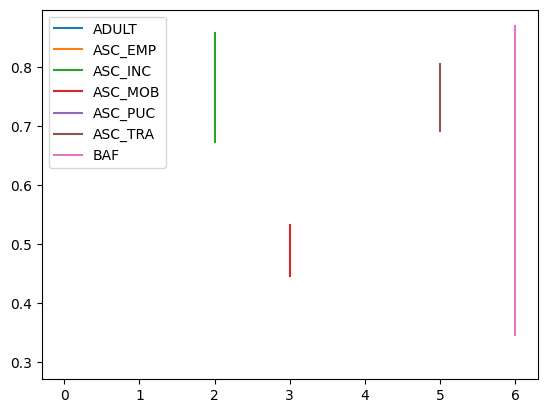

In [ ]:
for count, folder in enumerate(folders_name):
    DI_ini = np.load('../Result/' + folder + '/DI.npy')
    plt.plot([count, count], [DI_ini, dic_result[folder][dic_sample_size_folder[folder][0]]], label = folder)
    new_DI = dic_result[folder][dic_sample_size_folder[folder][0]]
    if new_DI is None:
        print(folder, DI_ini.round(2), None)
    else:
        print(folder, DI_ini.round(2), np.round((new_DI), 2))
plt.legend()
plt.show()